# 4.0: Import Packages

In [2]:
# Administrative stuff:
import os

# For Data manipulation:
import pandas as pd
import numpy as np
import random
import re

# Regression/viz 
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

## dynamic text updating
from IPython.display import Markdown as md

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%xmode Minimal

Exception reporting mode: Minimal


# 4.1: Getting Data from Other Files

In [3]:
%store -r air_data
%store -r air_ken
%store -r air_ken_2019
%store -r health_county_names
%store -r health_data
%store -r health_ken
%store -r health_ken_2019
%store -r health_ken_2019_clean
%store -r health_ken_2019_fm
%store -r so2
%store -r so2_county_names
%store -r so2_ken
%store -r so2_ken_f
%store -r good_days_ken
%store -r daily_aqi
%store -r daily_aqi_ken
%store -r so2_reshape
%store -r merged_ahs
%store -r merged_ah

## 4.1.1: Reworking Health Data:

In [4]:
# Looks like there are multiple counts for every MeasureId
test_jefferson_asthma = health_ken_2019_fm.loc[(health_ken_2019_fm.CountyName == "Jefferson") & 
                                               (health_ken_2019_fm.MeasureId == 'CASTHMA')]
test_jefferson_asthma.shape


def county_measure_count(county, measureid):
    df = health_ken_2019_fm[(health_ken_2019_fm.CountyName == county) & 
                                           (health_ken_2019_fm.MeasureId == measureid)]
    return ("County: " + county, "MeasureId: " + measureid, "Num of values: " + str(df.shape[0]))

health_county_measure_count = [county_measure_count(county = x, measureid = "CASTHMA") for x 
                               in health_ken_2019_fm.CountyName.unique()]

#health_county_measure_count

def county_measure_stats(county, measureid):
    df = health_ken_2019_fm[(health_ken_2019_fm.CountyName == county) & 
                             (health_ken_2019_fm.MeasureId == measureid)]
    return ("County: " + county, "MeasureId: " + measureid, "Max: " + str(df.Data_Value.max()), 
            'Min: ' + str(df.Data_Value.min()), "Diff: " + str(df.Data_Value.max() - df.Data_Value.min()), 
            "Mean: " + str(df.Data_Value.mean()), "Median: " + str(df.Data_Value.median()))

health_county_measure_stats = [county_measure_stats(county = x, measureid = "CASTHMA") for x 
                               in health_ken_2019_fm.CountyName.unique()]

#health_county_measure_stats

(190, 13)

In [5]:
# Create a new health df to ensure only one data value measure per county

#group by county and take mean to create new columns then pivot wide

health_avg = health_ken_2019_fm.groupby(['CountyName', 'MeasureId'])['Data_Value'].mean().reset_index()

#health_avg.head()

health_avg_piv = pd.pivot(health_avg[['CountyName', "MeasureId", 'Data_Value']],
                       index = ['CountyName'],
                       columns = ['MeasureId'],
                       values = ['Data_Value']).reset_index().copy()

#health_avg_piv.head()
health_avg_piv.columns = ["county", "ACCESS2_ADV", "BPMED_ADV", 'CANCER_ADV', 'CASTHMA_ADV', 'CHECKUP_ADV', 'COPD_ADV', 
                        'CSMOKING_ADV', 'DEPRESSION_ADV', 'GHLTH_ADV', 'LPA_ADV', 'MHLTH_ADV', 'PHLTH_ADV']

health_avg_piv.head()

,county,ACCESS2_ADV,BPMED_ADV,CANCER_ADV,CASTHMA_ADV,CHECKUP_ADV,COPD_ADV,CSMOKING_ADV,DEPRESSION_ADV,GHLTH_ADV,LPA_ADV,MHLTH_ADV,PHLTH_ADV
0,Adair,11.842857,78.528571,7.800000,10.571429,80.814286,12.457143,28.285714,27.185714,27.500000,39.300000,18.957143,18.800000
1,Allen,11.400000,78.550000,7.666667,10.450000,80.933333,11.616667,27.516667,27.066667,25.916667,36.733333,18.333333,18.016667
2,Anderson,9.540000,76.960000,7.340000,9.920000,81.560000,9.600000,23.480000,26.960000,21.580000,31.500000,16.940000,15.400000
3,Ballard,10.466667,79.400000,8.266667,10.300000,82.566667,11.700000,24.766667,27.266667,24.866667,34.066667,17.466667,17.566667
4,Barren,12.010000,79.220000,7.790000,10.500000,81.370000,12.400000,28.020000,27.660000,26.770000,38.090000,19.010000,18.730000


In [6]:
# Merge into two datasets  columsn so I can work on them 

merged_air_health = pd.merge(air_ken_2019, health_avg_piv, how = "left", left_on = "County", right_on = "county", 
                          suffixes=('_air', '_health'))

len(merged_air_health.county.unique())

merged_sulfur_health = pd.merge(so2_reshape, health_avg_piv, how = "left", left_on = "County Name", right_on = "county", 
                          suffixes=('_air', '_health'))

len(merged_sulfur_health.county.unique())

#merged_air_health.shape
#merged_sulfur_health.shape
#so2_reshape.columns

27

10

## 4.1.2: Reworking Air Quality

In [7]:
# Explore best independent variable options 

#merged_air_health['Unhealthy Days'].max()        # yields 0
#merged_air_health['Very Unhealthy Days'].max()   # yields 0
#merged_air_health['Unhealthy for Sensitive Groups Days'].max()   # yields 2
#merged_air_health['Moderate Days'].max()         # yields 163
#merged_air_health['Moderate Days'].mean()        # yields 136.2014008112612  # yields 41?
#merged_air_health['Moderate Days'].median()      # yields 163  #yields 29
#merged_air_health['Moderate Days'].min()         # yields 5
#merged_air_health['Median AQI'].max()            # yields 49 and falls under "Good Days" range 
#merged_air_health['Median AQI'].min()            # yields 36 and falls under "Good Days" range
#merged_air_health['Max AQI'].min()               # yields 58 and falls under 'moderate' range
#merged_air_health['Max AQI'].max()               # yields 136 and falls under 'unhelahty for sensistive groups' range
#merged_air_health['Days xwith AQI'].max()         # yields 365
#merged_air_health['Days with AQI'].min()         # yields 59
#merged_air_health['Days with AQI'].mean()        # yields 302.6666666666667

#Create two new variable to measure the percentage of good days vs moderate+ days  
merged_air_health["perc_moderateplus_days"] = (merged_air_health["Moderate Days"]+
                                              merged_air_health["Unhealthy for Sensitive Groups Days"])/merged_air_health["Days with AQI"]

#merged_air_health['perc_moderateplus_days'].max()     # Yields 0.4520547945205479
#merged_air_health['perc_moderateplus_days'].mean()    # Yields 0.13746723185772702
#merged_air_health['perc_moderateplus_days'].min()     # Yields 0.02066115702479339

merged_air_health["perc_good_days"] = merged_air_health["Good Days"]/merged_air_health["Days with AQI"]

#merged_air_health['perc_good_days'].max()     # Yields 0.9793388429752066
#merged_air_health['perc_good_days'].mean()    # Yields 0.862532768142273
#merged_air_health['perc_good_days'].min()     # Yields 0.547945205479452

#merged_air_health.sample(2)
#merged_air_health.columns

In [8]:
def aqi_reg(y_var, chart_title, y_label):
    sns.regplot(x= "perc_moderateplus_days",
                y= y_var,
                data= merged_air_health,
                ci=None,
                scatter_kws={'alpha': 0.5})
    plt.title(chart_title)
    plt.xlabel("Percentage of Moderate+ AQI Days")
    plt.ylabel(y_label)
    plt.figtext(0.12, 0.00001, "Based on 2019 CDC and EPA data for adults in 27 Kentucky counties", wrap=True,
                horizontalalignment='left', fontsize=7)
    
def aqi_model(y_var):
    dep_variable = merged_air_health[y_var]
    ind_variable = merged_air_health["perc_moderateplus_days"]
    model = ols('dep_variable ~ ind_variable', data= merged_air_health)
    model = model.fit()
    return print(model.summary())

# 4.2: Analyzing Air Quality and Overall Health

## 4.2.0: General Health

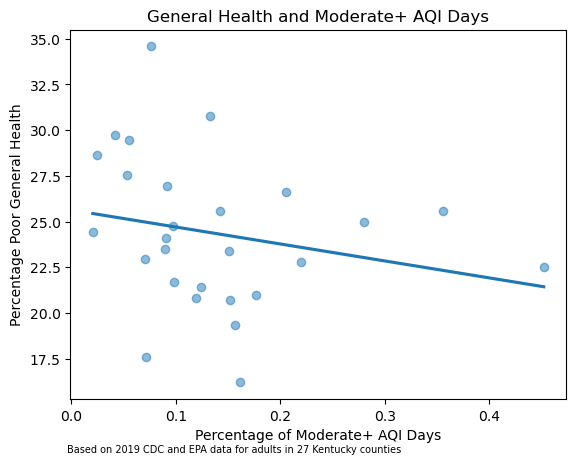

In [9]:
# General Health: Fair or poor self-rated health status among adults aged >=18 years
aqi_reg(y_var = "GHLTH_ADV", 
        chart_title = "General Health and Moderate+ AQI Days", 
        y_label = "Percentage Poor General Health")

# For paper save figure
plt.savefig("4.2.0_aqi_genhealth.png")

## As percentage of moderate or worse air quality days increases, less people report poor overall health...

In [10]:
# General Health model
aqi_model(y_var = "GHLTH_ADV")

# BUT not at a significant level

                            OLS Regression Results                            
Dep. Variable:           dep_variable   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.292
Date:                Tue, 06 Dec 2022   Prob (F-statistic):              0.266
Time:                        23:22:36   Log-Likelihood:                -75.445
No. Observations:                  27   AIC:                             154.9
Df Residuals:                      25   BIC:                             157.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       25.6290      1.374     18.658   

## 4.2.1: Physical Health

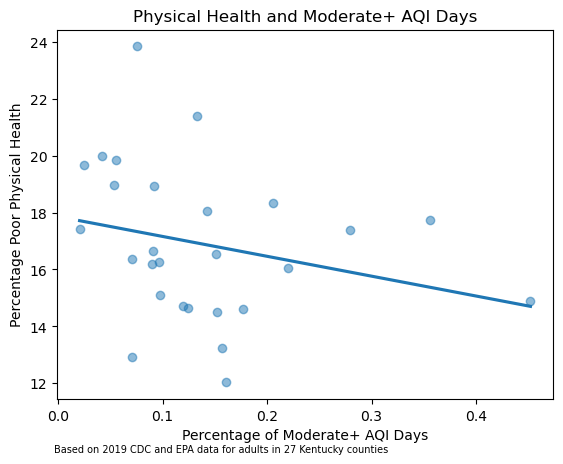

In [11]:
# Physical health not good for >=14 days among adults aged >=18 years 
aqi_reg(y_var = "PHLTH_ADV",
        chart_title = "Physical Health and Moderate+ AQI Days", 
        y_label = "Percentage Poor Physical Health")

## As percentage of moderate or worse air quality days increases, less people report poor physical health...

In [12]:
# Physical health model
aqi_model(y_var = "PHLTH_ADV")
## BUT not at a significant level

                            OLS Regression Results                            
Dep. Variable:           dep_variable   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.732
Date:                Tue, 06 Dec 2022   Prob (F-statistic):              0.200
Time:                        23:22:36   Log-Likelihood:                -63.814
No. Observations:                  27   AIC:                             131.6
Df Residuals:                      25   BIC:                             134.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       17.8609      0.893     20.004   

## 4.2.3: Air Quality and Respiratory Health Condidtions

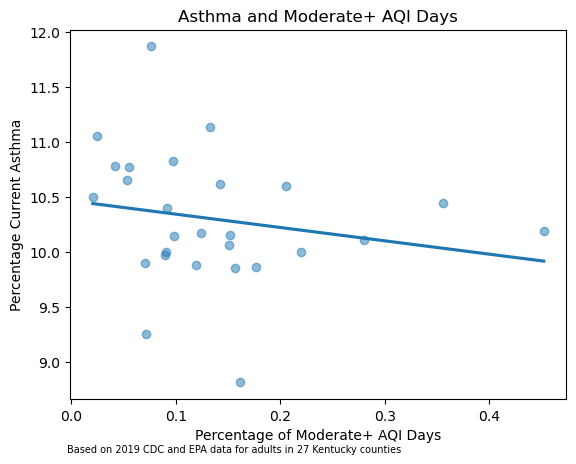

In [13]:
# Asthma: Current Asthma among adults aged >=18 years
aqi_reg(y_var = "CASTHMA_ADV",
        chart_title = "Asthma and Moderate+ AQI Days", 
        y_label = "Percentage Current Asthma")

## As percentage of moderate or worse air quality days increases, less people report asthma...

In [14]:
# Asthma Model
aqi_model(y_var = "CASTHMA_ADV")

## BUT not at a signficant level

                            OLS Regression Results                            
Dep. Variable:           dep_variable   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.038
Date:                Tue, 06 Dec 2022   Prob (F-statistic):              0.318
Time:                        23:22:36   Log-Likelihood:                -23.424
No. Observations:                  27   AIC:                             50.85
Df Residuals:                      25   BIC:                             53.44
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.4640      0.200     52.311   

## 4.2.4: Air Quality and COPD

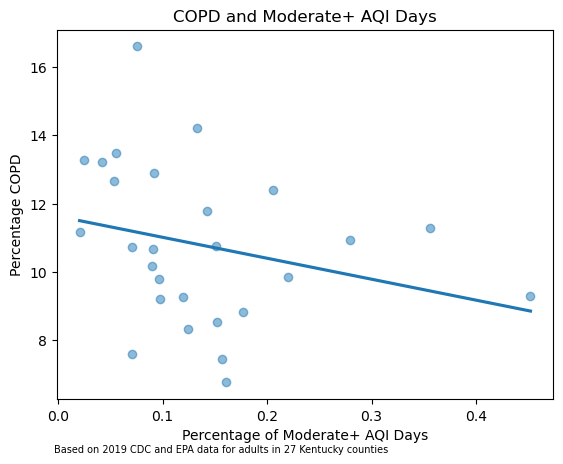

In [15]:
# COPD: Chronic obstructive pulmonary disease among adults aged >=18 years
aqi_reg(y_var = "COPD_ADV",
        chart_title = "COPD and Moderate+ AQI Days", 
        y_label = "Percentage COPD")

## As percentage of moderate or worse air quality days increases, less people report COPD...

In [16]:
# COPD Model
aqi_model(y_var = "COPD_ADV")

## BUT not at a significant level

                            OLS Regression Results                            
Dep. Variable:           dep_variable   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     1.851
Date:                Tue, 06 Dec 2022   Prob (F-statistic):              0.186
Time:                        23:22:36   Log-Likelihood:                -59.413
No. Observations:                  27   AIC:                             122.8
Df Residuals:                      25   BIC:                             125.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       11.6263      0.759     15.327   

## 4.2.5: Air Quality and Cancer

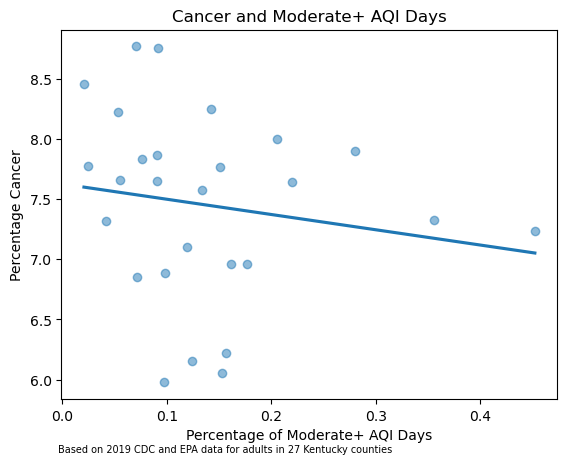

In [17]:
# Cancer (excluding skin cancer) among adults aged >=18 years
aqi_reg(y_var = "CANCER_ADV",
        chart_title = "Cancer and Moderate+ AQI Days", 
        y_label = "Percentage Cancer")

## As percentage of moderate or worse air quality days increases, less people report cancer...

In [18]:
# Cancer model
aqi_model(y_var = "CANCER_ADV")

## BUT not at a significant level

                            OLS Regression Results                            
Dep. Variable:           dep_variable   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.6763
Date:                Tue, 06 Dec 2022   Prob (F-statistic):              0.419
Time:                        23:22:36   Log-Likelihood:                -30.427
No. Observations:                  27   AIC:                             64.85
Df Residuals:                      25   BIC:                             67.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.6249      0.259     29.409   

## 4.2.6: Air Quality and Mental Health

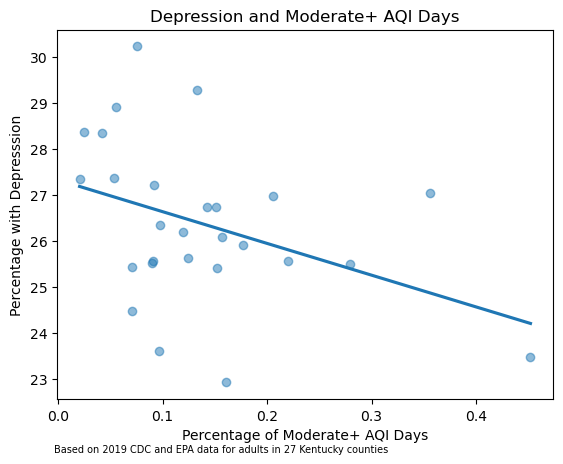

In [19]:
# Depression among adults aged >=18 years
aqi_reg(y_var = "DEPRESSION_ADV",
        chart_title = "Depression and Moderate+ AQI Days", 
        y_label = "Percentage with Depresssion")

# For paper save figure
plt.savefig("4.2.6_aqi_depression.png")

## As percentage of moderate or worse air quality days increases, less people report cancer...

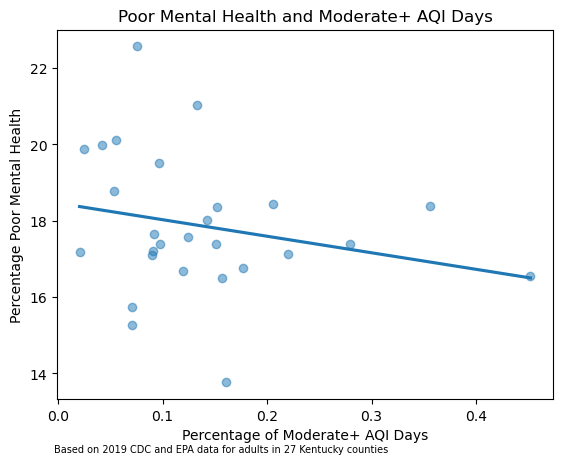

In [20]:
# Mental health not good for >=14 days among adults aged >=18 years
aqi_reg(y_var = "MHLTH_ADV",
        chart_title = "Poor Mental Health and Moderate+ AQI Days", 
        y_label = "Percentage Poor Mental Health")

## As percentage of moderate or worse air quality days increases, less people report negative mental health...

In [21]:
# Depression Model
aqi_model(y_var = "DEPRESSION_ADV")

## BUT Not at a significant level

                            OLS Regression Results                            
Dep. Variable:           dep_variable   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     4.545
Date:                Tue, 06 Dec 2022   Prob (F-statistic):             0.0430
Time:                        23:22:37   Log-Likelihood:                -50.454
No. Observations:                  27   AIC:                             104.9
Df Residuals:                      25   BIC:                             107.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       27.3220      0.544     50.191   

In [22]:
# Mental model
aqi_model(y_var = "MHLTH_ADV")

## BUT not at a significant level

                            OLS Regression Results                            
Dep. Variable:           dep_variable   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.445
Date:                Tue, 06 Dec 2022   Prob (F-statistic):              0.241
Time:                        23:22:37   Log-Likelihood:                -53.369
No. Observations:                  27   AIC:                             110.7
Df Residuals:                      25   BIC:                             113.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       18.4607      0.606     30.442   

# 4.3: Sulfur Dioxide

In [23]:
def sulfur_reg(measure, chart_title, y_label):
    sns.regplot(x='so2_avg_aqi',
                y= measure,
                data= merged_sulfur_health,
                ci=None,
                scatter_kws={'alpha': 0.5})
    plt.title(chart_title)
    plt.xlabel("Mean SO2 AQI Observation")
    plt.ylabel(y_label)
    plt.figtext(0.12, 0.00001, "Based on 2019 CDC and EPA data for adults in 10 Kentucky counties", wrap=True,
                horizontalalignment='left', fontsize=7)

In [24]:
def sulfur_model(measure):
    dep_variable = merged_sulfur_health[measure]
    observation_mean = merged_sulfur_health['so2_avg_aqi']
    model = ols('dep_variable ~ observation_mean', data= merged_sulfur_health)
    model = model.fit()
    return print(model.summary())

### 4.3.1: Sulfur and Overall Health

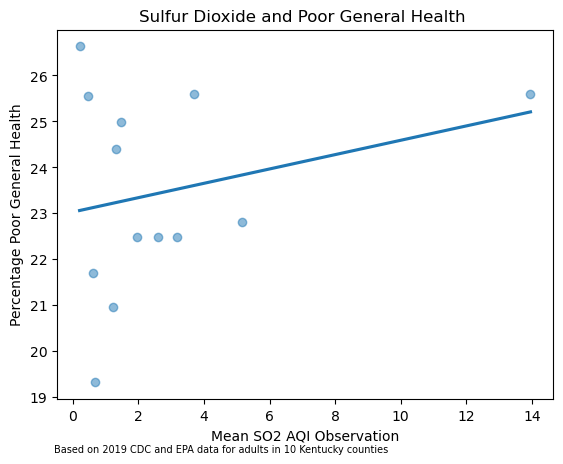

In [39]:
# Overall Health: Fair or poor self-rated health status among adults aged >=18 years
sulfur_reg(measure = "GHLTH_ADV",
          chart_title = "Sulfur Dioxide and Poor General Health ",
          y_label = "Percentage Poor General Health")

# For paper, refine and save as png
plt.savefig("4.3.1_sulfur_genhealth.png")

## As avg sulfur counts increase, more people report fair or poor overall health...

In [26]:
# Overall Health Model
sulfur_model(measure = "GHLTH_ADV")

# BUT not at a signficant level 

                            OLS Regression Results                            
Dep. Variable:           dep_variable   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.8134
Date:                Tue, 06 Dec 2022   Prob (F-statistic):              0.386
Time:                        23:22:37   Log-Likelihood:                -27.541
No. Observations:                  13   AIC:                             59.08
Df Residuals:                      11   BIC:                             60.21
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           23.0261      0.778  

C:\Users\Sanha Tahir\anaconda3\envs\my-env\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


## 4.3.2: Sulfur and Physical Health

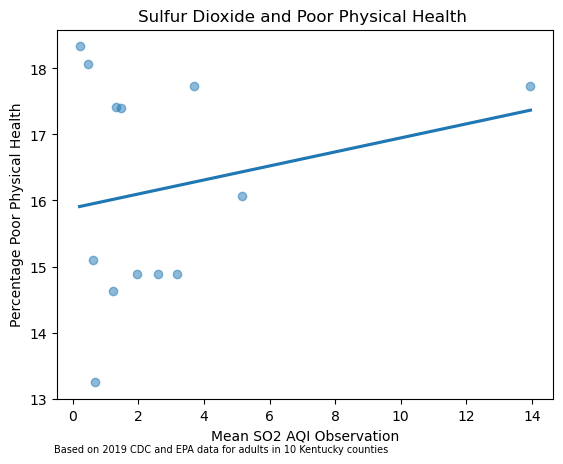

In [27]:
# Physical health not good for >=14 days among adults aged >=18 years 
sulfur_reg(measure = "PHLTH_ADV",
           chart_title = "Sulfur Dioxide and Poor Physical Health ",
           y_label = "Percentage Poor Physical Health")

## As avg sulfur counts increase, more people report poor physical health...

In [28]:
# Physical health model

sulfur_model("PHLTH_ADV")

# BUT not at a significant level

                            OLS Regression Results                            
Dep. Variable:           dep_variable   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.6295
Date:                Tue, 06 Dec 2022   Prob (F-statistic):              0.444
Time:                        23:22:37   Log-Likelihood:                -24.185
No. Observations:                  13   AIC:                             52.37
Df Residuals:                      11   BIC:                             53.50
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           15.8858      0.601  

C:\Users\Sanha Tahir\anaconda3\envs\my-env\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


## 4.3.3: Sulfur and Respiratory Health Condidtions

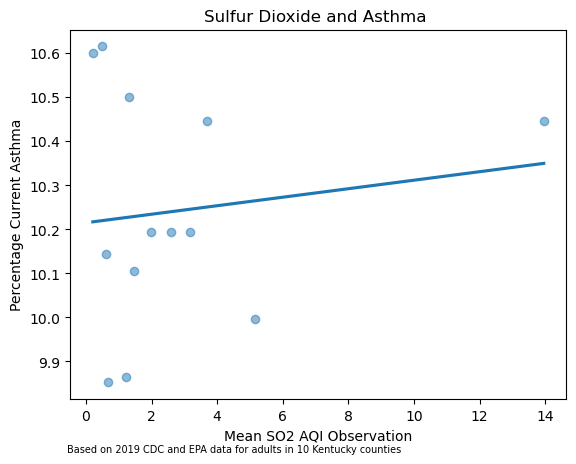

In [29]:
# Asthma: Current Asthma among adults aged >=18 years
sulfur_reg(measure = "CASTHMA_ADV",          
           chart_title = "Sulfur Dioxide and Asthma ",
           y_label = "Percentage Current Asthma")

## As avg sulfur counts increase, more people report asthma...

In [30]:
# Asthma Model

sulfur_model(measure = "CASTHMA_ADV")

# BUT not at a significant level 

                            OLS Regression Results                            
Dep. Variable:           dep_variable   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.071
Method:                 Least Squares   F-statistic:                    0.2064
Date:                Tue, 06 Dec 2022   Prob (F-statistic):              0.658
Time:                        23:22:37   Log-Likelihood:               -0.26311
No. Observations:                  13   AIC:                             4.526
Df Residuals:                      11   BIC:                             5.656
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           10.2150      0.095  

C:\Users\Sanha Tahir\anaconda3\envs\my-env\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


## 4.3.4: Suflur and COPD:

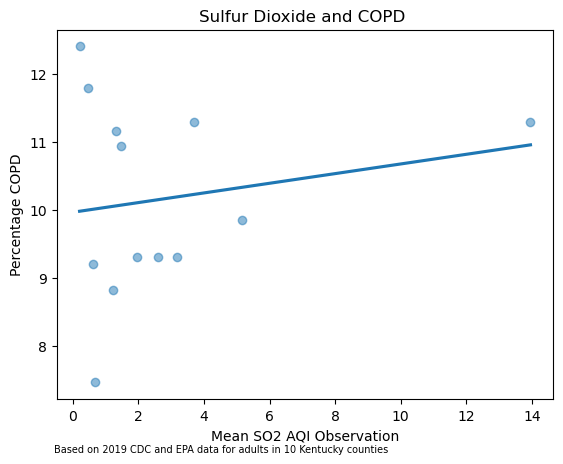

In [31]:
# COPD: Chronic obstructive pulmonary disease among adults aged >=18 years
sulfur_reg(measure = "COPD_ADV",
           chart_title = "Sulfur Dioxide and COPD ",
           y_label = "Percentage COPD")

## As avg sulfur counts increase, more people report COPD...

In [32]:
# COPD Model

sulfur_model("COPD_ADV")

# BUT not at a significant level

                            OLS Regression Results                            
Dep. Variable:           dep_variable   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                 -0.054
Method:                 Least Squares   F-statistic:                    0.3801
Date:                Tue, 06 Dec 2022   Prob (F-statistic):              0.550
Time:                        23:22:38   Log-Likelihood:                -22.225
No. Observations:                  13   AIC:                             48.45
Df Residuals:                      11   BIC:                             49.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            9.9631      0.517  

C:\Users\Sanha Tahir\anaconda3\envs\my-env\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


## 4.3.4: Sulfur and Cancer

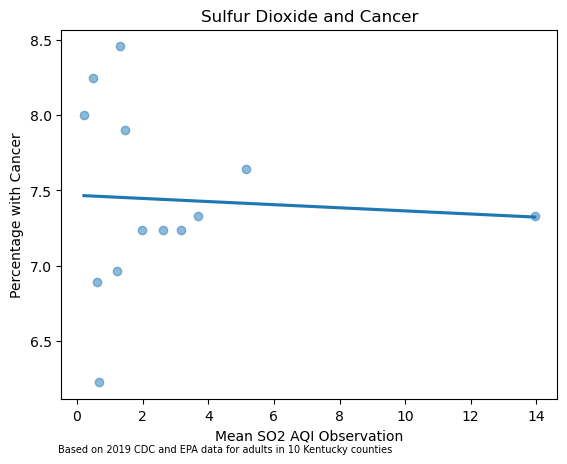

In [33]:
# Cancer (excluding skin cancer) among adults aged >=18 years
sulfur_reg(measure = "CANCER_ADV",           
           chart_title = "Sulfur Dioxide and Cancer",
           y_label = "Percentage with Cancer")

## As avg sulfur counts increase, less people report cancer...

In [34]:
# Cancer model
sulfur_model(measure = "CANCER_ADV")

## BUT not at a significant level

                            OLS Regression Results                            
Dep. Variable:           dep_variable   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.087
Method:                 Least Squares   F-statistic:                   0.04274
Date:                Tue, 06 Dec 2022   Prob (F-statistic):              0.840
Time:                        23:22:38   Log-Likelihood:                -11.386
No. Observations:                  13   AIC:                             26.77
Df Residuals:                      11   BIC:                             27.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.4667      0.225  

C:\Users\Sanha Tahir\anaconda3\envs\my-env\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### 4.3.5: Sulfur and Mental Health

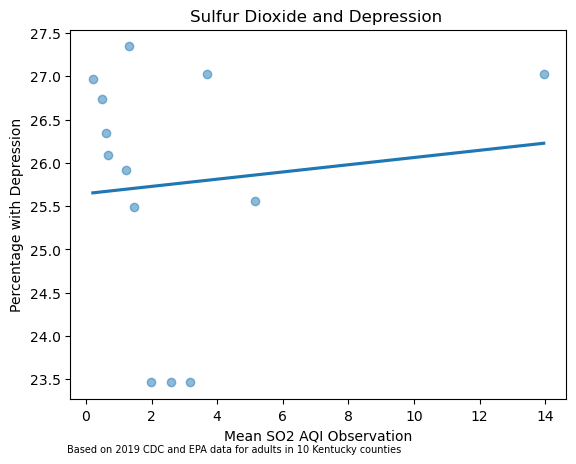

In [35]:
# Depression among adults aged >=18 years
sulfur_reg(measure = "DEPRESSION_ADV",
           chart_title = "Sulfur Dioxide and Depression ",
           y_label = "Percentage with Depression")

## As avg sulfur counts increase, more people report depression...

In [36]:
# Depression model
sulfur_model(measure = "DEPRESSION_ADV")

## BUT not at a significant level

                            OLS Regression Results                            
Dep. Variable:           dep_variable   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.079
Method:                 Least Squares   F-statistic:                    0.1256
Date:                Tue, 06 Dec 2022   Prob (F-statistic):              0.730
Time:                        23:22:38   Log-Likelihood:                -22.505
No. Observations:                  13   AIC:                             49.01
Df Residuals:                      11   BIC:                             50.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           25.6440      0.528  

C:\Users\Sanha Tahir\anaconda3\envs\my-env\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


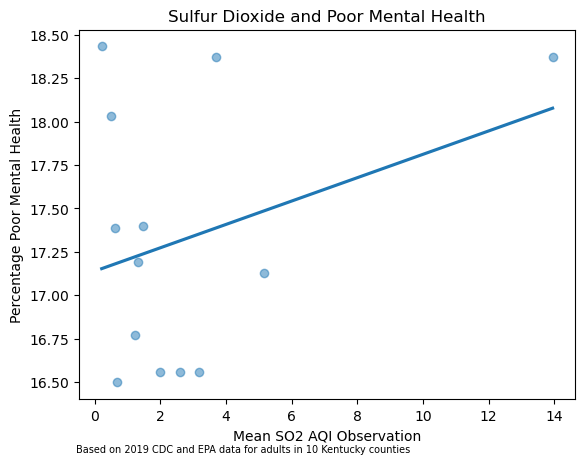

In [37]:
# Mental health not good for >=14 days among adults aged >=18 years
mental_mentalhealth_model = sulfur_reg("MHLTH_ADV",
          chart_title = "Sulfur Dioxide and Poor Mental Health",
          y_label = "Percentage Poor Mental Health")

## Avg sulfur counts increase, more people report negative mental health...

In [38]:
# Mental health model
sulfur_mentalhealth_model = sulfur_model("MHLTH_ADV")
mental_mentalhealth_model


## BUT not at a significant level

                            OLS Regression Results                            
Dep. Variable:           dep_variable   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.320
Date:                Tue, 06 Dec 2022   Prob (F-statistic):              0.275
Time:                        23:22:38   Log-Likelihood:                -13.436
No. Observations:                  13   AIC:                             30.87
Df Residuals:                      11   BIC:                             32.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           17.1387      0.263  

C:\Users\Sanha Tahir\anaconda3\envs\my-env\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
